In [1]:
#install library yg mau digunakan
!pip install pandas
!pip install nltk
!pip install scikit-learn
!pip install wordcloud
!pip install openpyxl

In [6]:
# Download files from GitHub
!wget -q -O lexiconlist.py https://raw.githubusercontent.com/hopefullycorrect/rulelex/main/py/lexiconlist.py
!wget -q -O rulelist.py https://raw.githubusercontent.com/hopefullycorrect/rulelex/main/py/rulelist.py
import urllib.request

# Download the Excel file
url = "https://raw.githubusercontent.com/hopefullycorrect/rulelex/main/py/IU.xlsx"
urllib.request.urlretrieve(url, "IU.xlsx")

# Import the downloaded files
import lexiconlist
import rulelist

# Verify the imports (show a small portion of the lexicon and rule lists)
print("Sample from lexicon:", list(lexiconlist.lexicon.items())[:5])
print("Sample from positive words:", rulelist.positive_words[:5])
print("Sample from negative words:", rulelist.negative_words[:5])

Sample from lexicon: [('putus tali gantung', -2), ('gelebah', 2), ('gobar hati', -2), ('tersentuh (perasaan)', -1), ('isak', -5)]
Sample from positive words: ['best', 'memorable', 'thank', 'enak', 'magical']
Sample from negative words: ['T_T', 'sedih', 'T.T', 'ancam', 'orgil']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Column names: Index(['Unnamed: 0', 'conversation_id_str', 'created_at', 'favorite_count',
       'full_text', 'id_str', 'image_url', 'in_reply_to_screen_name', 'lang',
       'location', 'quote_count', 'reply_count', 'retweet_count', 'tweet_url',
       'user_id_str', 'username', 'tweet', 'tweet_tokens',
       'tweet_tokens_fdist', 'tweet_tokens_WSW', 'tweet_normalized',
       'tweet_tokens_stemmed'],
      dtype='object')
      Unnamed: 0  conversation_id_str                      created_at  \
0              0  1785675393967763968  Thu May 02 11:36:14 +0000 2024   
1              1  1785978583573505024  Thu May 02 10:24:10 +0000 2024   
2              2  1785963648512672000  Thu May 02 10:03:31 +0000 2024   
3              3  1785969551362203904  Thu May 02 09:48:17 +0000 2024   
4              4  1785851497529704960  Thu May 02 02:09:35 +0000 2024   
...          ...                  ...                             ...   
1826        1826  1503697053599212032  Tue Mar 15 11:38:09 +

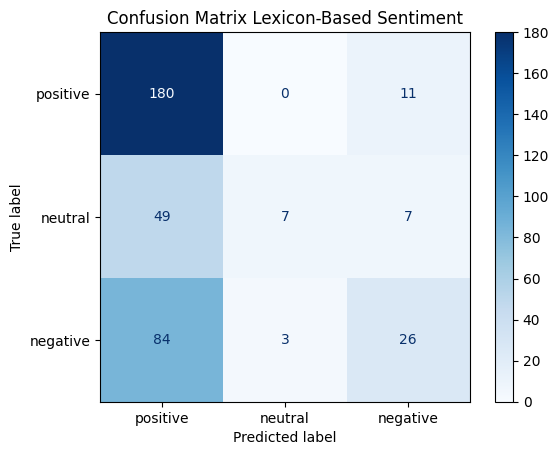

Classification Report Lexicon-Based Sentiment:
              precision    recall  f1-score   support

    positive       0.59      0.23      0.33       113
     neutral       0.70      0.11      0.19        63
    negative       0.58      0.94      0.71       191

    accuracy                           0.58       367
   macro avg       0.62      0.43      0.41       367
weighted avg       0.60      0.58      0.51       367



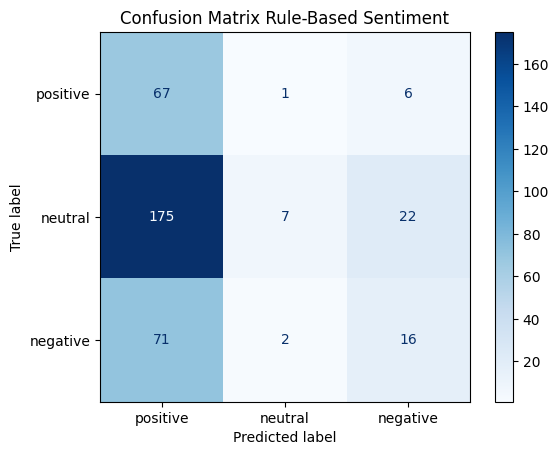

Classification Report Rule-Based Sentiment:
              precision    recall  f1-score   support

    positive       0.36      0.18      0.24        89
     neutral       0.70      0.03      0.07       204
    negative       0.21      0.91      0.35        74

    accuracy                           0.25       367
   macro avg       0.43      0.37      0.22       367
weighted avg       0.52      0.25      0.16       367



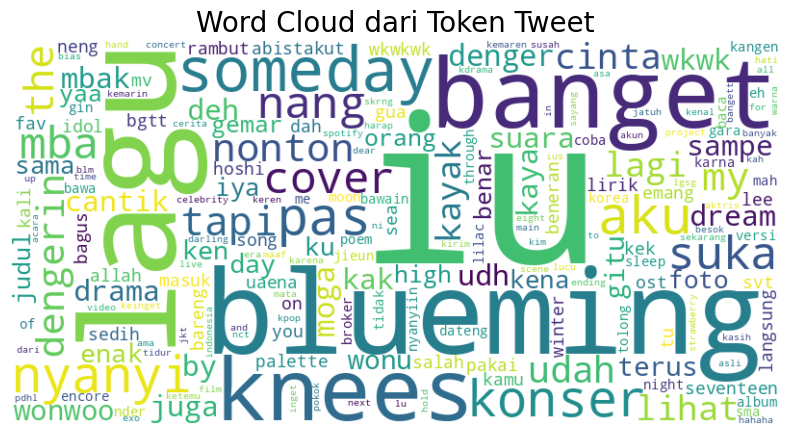

In [10]:
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import re
from lexiconlist import lexicon
from rulelist import positive_words, negative_words
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# Read the Excel file
df = pd.read_excel('/content/IU.xlsx')

# Print the column names to verify
print("Column names:", df.columns)

# Verify if 'full_text' column exists
if 'full_text' not in df.columns:
    raise KeyError("The column 'full_text' does not exist in the Excel file.")

# Extract the 'full_text' column
texts = df['full_text']

# Apply tokenization to each text in the column
df['tokens'] = texts.apply(word_tokenize)

# Define regex patterns for positive and negative words, allowing for elongated characters
def create_elongated_pattern(word_list):
    return re.compile(r'|'.join([rf"\b{''.join([char + r'+' for char in word])}\b" for word in word_list]), re.IGNORECASE)

positive_pattern = create_elongated_pattern(positive_words)
negative_pattern = create_elongated_pattern(negative_words)

# Define a function to apply rule-based sentiment analysis
def rule_based_sentiment(tokens):
    sentiment_score_rule = 0
    token_text = ' '.join(tokens)

    # Count the number of positive and negative words
    positive_matches = positive_pattern.findall(token_text)
    negative_matches = negative_pattern.findall(token_text)

    # Adjust sentiment score based on matches
    sentiment_score_rule += len(positive_matches)
    sentiment_score_rule -= len(negative_matches)

    return sentiment_score_rule

# Apply the rule-based sentiment analysis to each element in the 'tokens' column
df['sentiment_rule'] = df['tokens'].apply(rule_based_sentiment)

# Label sentiments based on rule-based score
df['label_rulesentiment'] = df['sentiment_rule'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

# Define a function to calculate sentiment score for a list of tokens
def calculate_sentiment(tokens):
    sentiment_score = 0
    for word in tokens:
        if word in lexicon:
            sentiment_score += lexicon[word]
    return sentiment_score

# Apply the function to each element in the 'tokens' column
df['sentiment_score'] = df['tokens'].apply(calculate_sentiment)

# Label sentiments based on lexicon-based score
df['label_sentiment'] = df['sentiment_score'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

# Print the dataframe to check the result
print(df)

# Save the labeled data to a new Excel file
df.to_excel('positive_negativeupdta.xlsx', index=False)

# Prepare data for machine learning
X = df['full_text']
y = df['label_sentiment']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize text data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train Naive Bayes classifier
clf = MultinomialNB()
clf.fit(X_train_vec, y_train)

# Predict on test data
y_pred = clf.predict(X_test_vec)

# Confusion matrix for lexicon-based sentiment analysis
cm_lexicon = confusion_matrix(y_test, y_pred, labels=['positive', 'neutral', 'negative'])
disp_lexicon = ConfusionMatrixDisplay(confusion_matrix=cm_lexicon, display_labels=['positive', 'neutral', 'negative'])
disp_lexicon.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix Lexicon-Based Sentiment')
plt.show()

# Classification report for lexicon-based sentiment analysis
print("Classification Report Lexicon-Based Sentiment:")
print(classification_report(y_test, y_pred, target_names=['positive', 'neutral', 'negative']))

# Confusion matrix for rule-based sentiment analysis
y_test_rule = df.loc[X_test.index, 'label_rulesentiment']
cm_rule = confusion_matrix(y_test_rule, y_pred, labels=['positive', 'neutral', 'negative'])
disp_rule = ConfusionMatrixDisplay(confusion_matrix=cm_rule, display_labels=['positive', 'neutral', 'negative'])
disp_rule.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix Rule-Based Sentiment')
plt.show()

# Classification report for rule-based sentiment analysis
print("Classification Report Rule-Based Sentiment:")
print(classification_report(y_test_rule, y_pred, target_names=['positive', 'neutral', 'negative']))

# Generate word cloud for most frequent words
tweet_tokens_stemmed = df['tweet_tokens_stemmed']

# Convert the list of lists into a single list of words
all_words_str = ', '.join(tweet_tokens_stemmed)

# Extract individual words enclosed by single ticks
all_words = re.findall(r"'(\w+)'", all_words_str)

# Convert the extracted words to lowercase
all_words = [word.lower() for word in all_words]

# Count the frequency of each word
word_counts = Counter(all_words)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Display the word cloud with a title
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud dari Token Tweet', fontsize=20)
plt.axis('off')

# Save the word cloud as a PNG file
plt.savefig('wordcloud.png', bbox_inches='tight', pad_inches=0.2)

# Save the word cloud as a JPG file
plt.savefig('wordcloud.jpg', bbox_inches='tight', pad_inches=0.2)
plt.show()
